# Nipype Quickstart - non-imaging

**This is a very quick non-imaging introduction to Nipype workflows. For a more comprehensive introduction, check the next section of the tutorial.** 

![Nipype architecture](https://raw.github.com/satra/intro2nipype/master/images/arch.png)

- [Existing documentation](http://nipype.readthedocs.io/en/latest/)

- [Visualizing the evolution of Nipype](https://www.youtube.com/watch?v=cofpD1lhmKU)

- This notebook is taken from [reproducible-imaging repository](https://github.com/ReproNim/reproducible-imaging)

#### Import a few things from nipype

In [1]:
import os
from nipype import Workflow, Node, Function

Creating Workflow with one Node that adds two numbers

In [2]:
def sum(a, b):
    return a + b

wf = Workflow('hello')

adder = Node(Function(input_names=['a', 'b'],
                      output_names=['sum'],
                      function=sum), 
             name='a_plus_b')

adder.inputs.a = 1
adder.inputs.b = 3

wf.add_nodes([adder])

wf.base_dir = os.getcwd()

eg = wf.run()

list(eg.nodes())[0].result.outputs

211017-18:07:54,305 nipype.workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:07:54,339 nipype.workflow INFO:
	 Running serially.
211017-18:07:54,340 nipype.workflow INFO:
	 [Node] Setting-up "hello.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/a_plus_b".
211017-18:07:54,377 nipype.workflow INFO:
	 [Node] Running "a_plus_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:54,434 nipype.workflow INFO:
	 [Node] Finished "hello.a_plus_b".



sum = 4

Creating a second node and connecting to the ``hello`` Workflow 

In [3]:
def concat(a, b):
    return [a, b]


concater = Node(Function(input_names=['a', 'b'],
                         output_names=['some_list'],
                         function=concat), 
                name='concat_a_b')

wf.connect(adder, 'sum', concater, 'a')
concater.inputs.b = 3

eg = wf.run()
print(eg.nodes())

211017-18:07:54,468 nipype.workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:07:54,516 nipype.workflow INFO:
	 Running serially.
211017-18:07:54,518 nipype.workflow INFO:
	 [Node] Setting-up "hello.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/a_plus_b".
211017-18:07:54,526 nipype.workflow INFO:
	 [Node] Outdated cache found for "hello.a_plus_b".
211017-18:07:54,565 nipype.workflow INFO:
	 [Node] Running "a_plus_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:54,603 nipype.workflow INFO:
	 [Node] Finished "hello.a_plus_b".
211017-18:07:54,605 nipype.workflow INFO:
	 [Node] Setting-up "hello.concat_a_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/concat_a_b".
211017-18:07:54,640 nipype.workflow INFO:
	 [Node] Running "concat_a_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:54,698 nipype.workflow INFO:
	 [Node] Finished "hello.concat_a_b".
[hello.a_plus_b

And we can check results of our Workflow, we should see a list:

In [4]:
list(eg.nodes())[-1].result.outputs


some_list = [4, 3]

We will try to add additional Node that adds one:

In [5]:
def plus_one(a):
    return a + 1

plusone = Node(Function(input_names=['a'],
                        output_names=['out'],
                        function=plus_one), 
               name='add_1')

wf.connect(concater, 'some_list', plusone, 'a')

try:
    eg = wf.run()
except(RuntimeError) as err:
    print("RuntimeError:", err)
else:
    raise

211017-18:07:54,731 nipype.workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:07:54,868 nipype.workflow INFO:
	 Running serially.
211017-18:07:54,869 nipype.workflow INFO:
	 [Node] Setting-up "hello.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/a_plus_b".
211017-18:07:54,907 nipype.workflow INFO:
	 [Node] Cached "hello.a_plus_b" - collecting precomputed outputs
211017-18:07:54,908 nipype.workflow INFO:
	 [Node] "hello.a_plus_b" found cached.
211017-18:07:54,910 nipype.workflow INFO:
	 [Node] Setting-up "hello.concat_a_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/concat_a_b".
211017-18:07:54,922 nipype.workflow INFO:
	 [Node] Outdated cache found for "hello.concat_a_b".
211017-18:07:54,958 nipype.workflow INFO:
	 [Node] Running "concat_a_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:55,13 nipype.workflow INFO:
	 [Node] Finished "hello.concat_a_b".
211017-18:07:55,14 n

This time the workflow didn't execute cleanly and we got an error. We can use ``nipypecli`` to read the crashfile (note, that if you have multiple crashfiles in the directory you'll have to provide a full name):

In [6]:
!nipypecli crash crash*

Usage: nipypecli crash [OPTIONS] CRASHFILE
Try 'nipypecli crash -h' for help.

Error: Got unexpected extra arguments (crash-20211017-171039-neuro-selectfiles-f56abef1-3008-4e84-941c-c2800895302b.txt crash-20211017-180755-neuro-add_1-7b3ed9c1-2c8c-44b6-9693-65e906a76506.pklz)


It clearly shows the problematic Node and its input. We tried to add an integer to a list, this operation is not allowed in Python. 

Let's try using MapNode

In [7]:
from nipype import MapNode

plusone = MapNode(Function(input_names=['a'],
                           output_names=['out'],
                           function=plus_one), 
                  iterfield=['a'],
                  name='add_1')

wf = Workflow('hello_mapnode')

adder = Node(Function(input_names=['a', 'b'],
                      output_names=['sum'],
                      function=sum), 
             name='a_plus_b')

adder.inputs.a = 1
adder.inputs.b = 3
wf.connect(adder, 'sum', concater, 'a')
concater.inputs.b = 3

wf.connect(concater, 'some_list', plusone, 'a')

wf.base_dir = os.getcwd()

eg = wf.run()
print(eg.nodes())

211017-18:07:56,314 nipype.workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:07:56,382 nipype.workflow INFO:
	 Running serially.
211017-18:07:56,383 nipype.workflow INFO:
	 [Node] Setting-up "hello_mapnode.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/a_plus_b".
211017-18:07:56,405 nipype.workflow INFO:
	 [Node] Running "a_plus_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:56,448 nipype.workflow INFO:
	 [Node] Finished "hello_mapnode.a_plus_b".
211017-18:07:56,449 nipype.workflow INFO:
	 [Node] Setting-up "hello.concat_a_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/concat_a_b".
211017-18:07:56,476 nipype.workflow INFO:
	 [Node] Cached "hello.concat_a_b" - collecting precomputed outputs
211017-18:07:56,477 nipype.workflow INFO:
	 [Node] "hello.concat_a_b" found cached.
211017-18:07:56,479 nipype.workflow INFO:
	 [Node] Setting-up "hello_mapnode.add_1"

Now the workflow finished without problems, let's see the results from ``hello.add_1``:

In [8]:
print(list(eg.nodes())[2].result.outputs)

Bunch(out=[5, 4])


And now we will run the example with ``iterables``:

In [9]:
adder.iterables = ('a', [1, 2])
adder.inputs.b = 2

eg = wf.run()
print(eg.nodes())

211017-18:07:56,695 nipype.workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:07:56,742 nipype.workflow INFO:
	 Running serially.
211017-18:07:56,743 nipype.workflow INFO:
	 [Node] Setting-up "hello_mapnode.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/_a_2/a_plus_b".
211017-18:07:56,765 nipype.workflow INFO:
	 [Node] Running "a_plus_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:56,796 nipype.workflow INFO:
	 [Node] Finished "hello_mapnode.a_plus_b".
211017-18:07:56,797 nipype.workflow INFO:
	 [Node] Setting-up "hello.concat_a_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/_a_2/concat_a_b".
211017-18:07:56,827 nipype.workflow INFO:
	 [Node] Running "concat_a_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:56,864 nipype.workflow INFO:
	 [Node] Finished "hello.concat_a_b".
211017-18:07:56,866 nipype.workflow INFO:
	 [Node] Setting-up "hell

Now we have 6 nodes, we can check results for `` hello.add_1.a1``

In [10]:
list(eg.nodes())[5].result.outputs

Bunch(out=[5, 4])

In [11]:
wf.write_graph(graph2use='exec')

211017-18:07:57,609 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/graph.png (graph2use=exec, simple_form=True).


'/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/graph.png'

In [12]:
from IPython.display import Image

We can plot a general structure of the workflow:

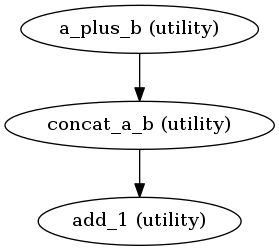

In [13]:
Image("hello_mapnode/graph.png")

And more detailed structure with all nodes:

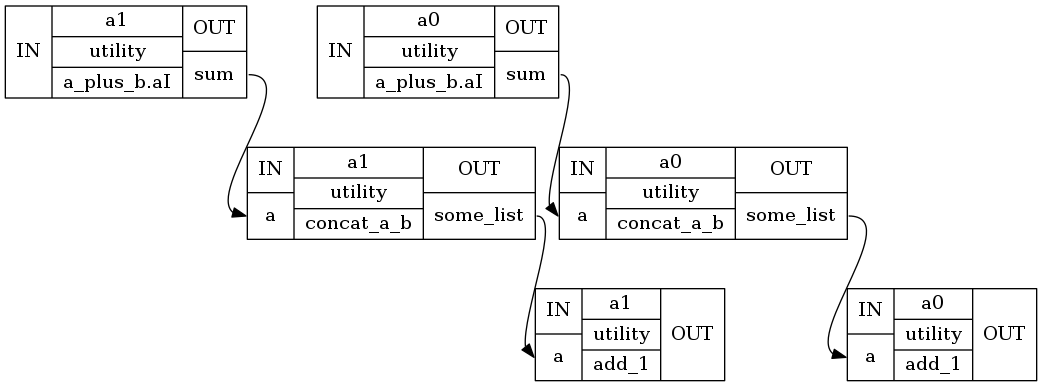

In [14]:
Image("hello_mapnode/graph_detailed.png")

We will introduce another iterables, for the concater Node:

In [15]:
concater.iterables = ('b', [3, 4])
eg = wf.run()
eg.nodes();

211017-18:07:57,705 nipype.workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:07:57,801 nipype.workflow INFO:
	 Running serially.
211017-18:07:57,802 nipype.workflow INFO:
	 [Node] Setting-up "hello_mapnode.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/_a_2/a_plus_b".
211017-18:07:57,828 nipype.workflow INFO:
	 [Node] Cached "hello_mapnode.a_plus_b" - collecting precomputed outputs
211017-18:07:57,829 nipype.workflow INFO:
	 [Node] "hello_mapnode.a_plus_b" found cached.
211017-18:07:57,831 nipype.workflow INFO:
	 [Node] Setting-up "hello.concat_a_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/_a_2/_b_4/concat_a_b".
211017-18:07:57,870 nipype.workflow INFO:
	 [Node] Running "concat_a_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:07:57,914 nipype.workflow INFO:
	 [Node] Finished "hello.concat_a_b".
211017-18:07:57,915 nipype.workflow INFO:
	 [Node] Setting-u

In [16]:
wf.write_graph(graph2use='exec')

211017-18:07:59,688 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/graph.png (graph2use=exec, simple_form=True).


'/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/graph.png'

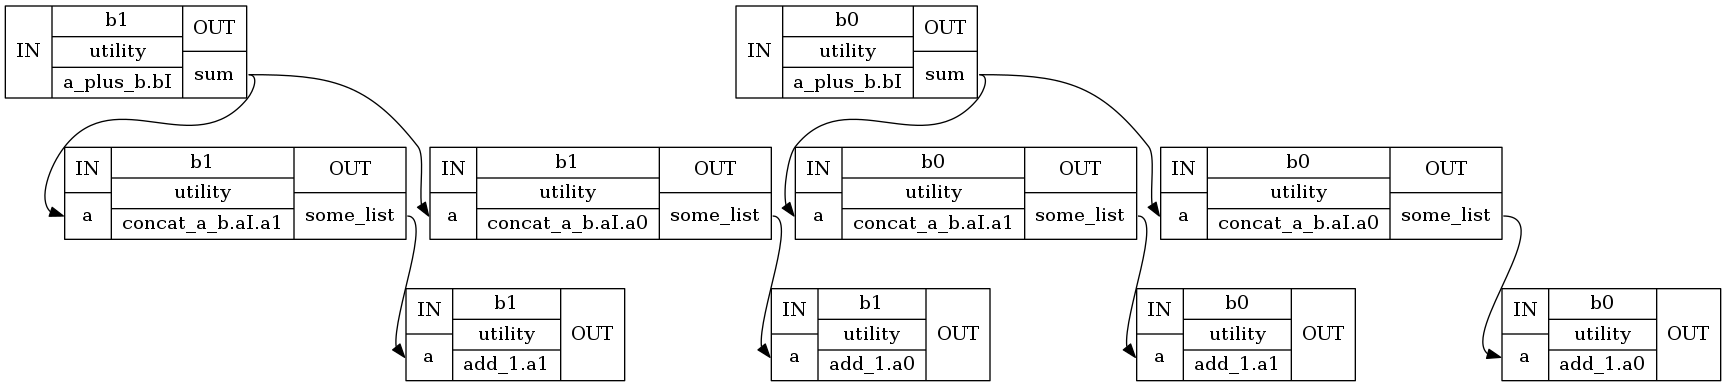

In [17]:
Image("hello_mapnode/graph_detailed.png")

Now we will introduce JoinNode that allows us to merge results together:

In [18]:
def merge_and_scale_data(data2):
    import numpy as np
    return (np.array(data2) * 1000).tolist()


from nipype import JoinNode
joiner = JoinNode(Function(input_names=['data2'],
                          output_names=['data_scaled'],
                          function=merge_and_scale_data),
                 name='join_scale_data',
                 joinsource=adder,
                 joinfield=['data2'])

wf.connect(plusone, 'out', joiner, 'data2')

eg = wf.run()
eg.nodes()

211017-18:07:59,729 nipype.workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:07:59,859 nipype.workflow INFO:
	 Running serially.
211017-18:07:59,861 nipype.workflow INFO:
	 [Node] Setting-up "hello_mapnode.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/_a_2/a_plus_b".
211017-18:07:59,884 nipype.workflow INFO:
	 [Node] Cached "hello_mapnode.a_plus_b" - collecting precomputed outputs
211017-18:07:59,886 nipype.workflow INFO:
	 [Node] "hello_mapnode.a_plus_b" found cached.
211017-18:07:59,887 nipype.workflow INFO:
	 [Node] Setting-up "hello.concat_a_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello/_a_2/_b_4/concat_a_b".
211017-18:07:59,925 nipype.workflow INFO:
	 [Node] Cached "hello.concat_a_b" - collecting precomputed outputs
211017-18:07:59,926 nipype.workflow INFO:
	 [Node] "hello.concat_a_b" found cached.
211017-18:07:59,929 nipype.workflow INFO:
	 [Node] Setting-up "hel

211017-18:08:02,211 nipype.workflow INFO:
	 [Node] Finished "hello_mapnode.join_scale_data".


NodeView((hello_mapnode.join_scale_data.a0, hello_mapnode.join_scale_data.a1, hello_mapnode.a_plus_b.bI.b0, hello.concat_a_b.aI.a0.b0, hello_mapnode.add_1.a0.b0, hello.concat_a_b.aI.a1.b0, hello_mapnode.add_1.a1.b0, hello_mapnode.a_plus_b.bI.b1, hello.concat_a_b.aI.a0.b1, hello_mapnode.add_1.a0.b1, hello.concat_a_b.aI.a1.b1, hello_mapnode.add_1.a1.b1))

Let's check the output of ``hello.join_scale_data.a0`` node:

In [19]:
list(eg.nodes())[0].result.outputs


data_scaled = [[4000, 4000], [5000, 4000]]

In [20]:
wf.write_graph(graph2use='exec')

211017-18:08:02,553 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/graph.png (graph2use=exec, simple_form=True).


'/home/neuro/workshop_weizmann/workshop/nipype/notebooks/hello_mapnode/graph.png'

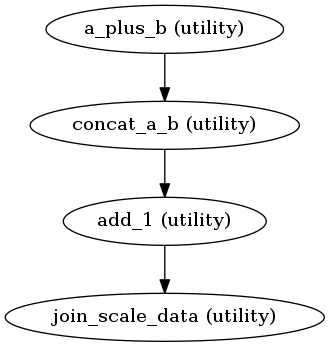

In [21]:
Image("hello_mapnode/graph.png")

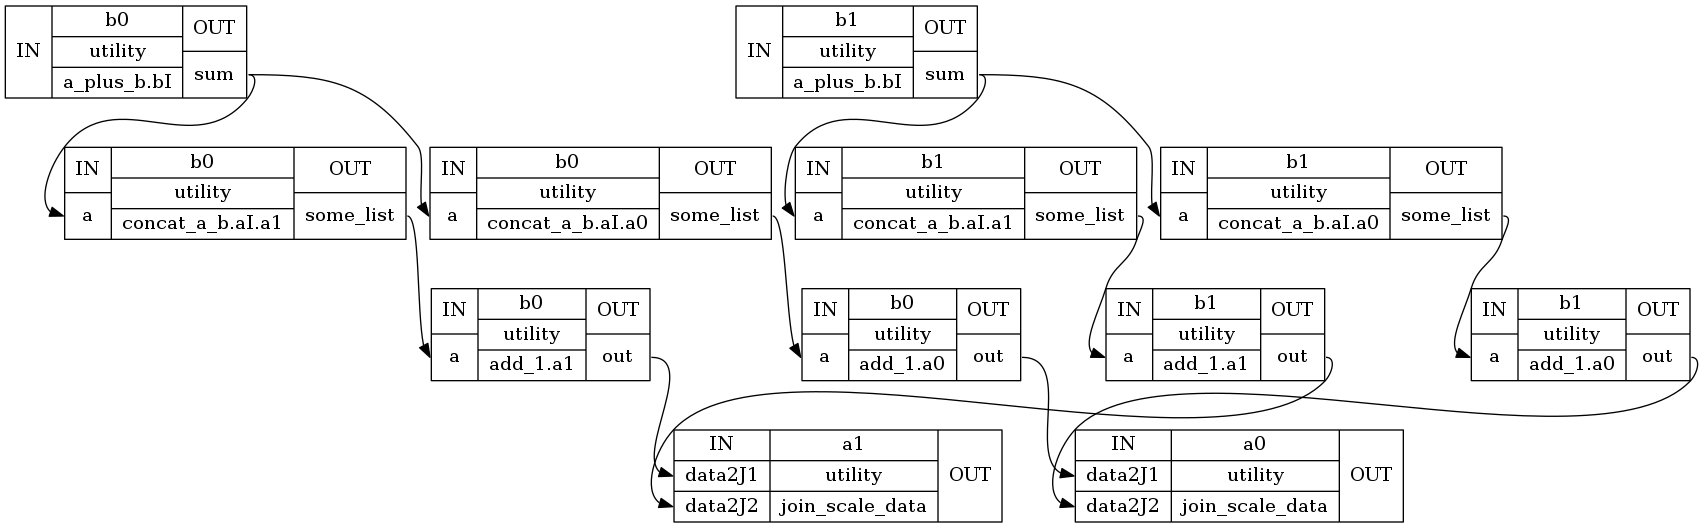

In [22]:
Image("hello_mapnode/graph_detailed.png")

In [23]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

211017-18:08:02,625 nipype.workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:08:02,754 nipype.workflow INFO:
	 Running in parallel.
211017-18:08:02,761 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 1.75/1.75, Free processors: 2/2.
211017-18:08:02,811 nipype.workflow INFO:
	 [Job 0] Cached (hello_mapnode.a_plus_b).
211017-18:08:02,828 nipype.workflow INFO:
	 [Job 5] Cached (hello_mapnode.a_plus_b).
211017-18:08:04,763 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 1.75/1.75, Free processors: 2/2.
211017-18:08:04,810 nipype.workflow INFO:
	 [Job 1] Cached (hello.concat_a_b).
211017-18:08:04,834 nipype.workflow INFO:
	 [Job 3] Cached (hello.concat_a_b).
211017-18:08:06,856 nipype.workflow INFO:
	 [Job 6] Cached (hello.concat_a_b).
211017-18:08:06,890 nipype.workflow INFO:
	 [Job 9] Cached (hello.concat_a_b).
211017-18:08:08,773 nipype.workflow INFO

In [24]:
wf.base_dir = os.path.join(os.getcwd(), 'alt')

In [25]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

211017-18:08:24,818 nipype.workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging', 'monitoring']
211017-18:08:24,864 nipype.workflow INFO:
	 Running in parallel.
211017-18:08:24,868 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 1.75/1.75, Free processors: 2/2.
211017-18:08:24,915 nipype.workflow INFO:
	 [Node] Setting-up "hello_mapnode.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/alt/hello_mapnode/_a_2/a_plus_b".
211017-18:08:24,919 nipype.workflow INFO:
	 [Node] Setting-up "hello_mapnode.a_plus_b" in "/home/neuro/workshop_weizmann/workshop/nipype/notebooks/alt/hello_mapnode/_a_1/a_plus_b".
211017-18:08:24,960 nipype.workflow INFO:
	 [Node] Running "a_plus_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:08:24,960 nipype.workflow INFO:
	 [Node] Running "a_plus_b" ("nipype.interfaces.utility.wrappers.Function")
211017-18:08:25,18 nipype.workflow INFO:
	 [Node] Finished "hello_mapn

In [26]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

### Exercise 1

Create a workflow to calculate a sum of factorials of numbers from a range between $n_{min}$ and $n_{max}$, i.e.:

$$\sum _{k=n_{min}}^{n_{max}} k! = 0! + 1! +2! + 3! + \cdots$$ 

if $n_{min}=0$ and $n_{max}=3$
$$\sum _{k=0}^{3} k! = 0! + 1! +2! + 3!  =  1 + 1 + 2 + 6 = 10$$


In [27]:
#write your code here

# 1. write 3 functions: one that returns a list of number from a specific range, 
#    second that returns n! (you can use math.factorial) and third, that sums the elements from a list

# 2. create a workflow and define the working directory

# 3. define 3 nodes using Node and MapNode and connect them within the workflow

# 4. run the workflow and check the results

In [28]:
from nipype import Workflow, Node, MapNode, Function
import os

def range_fun(n_min, n_max):
    return list(range(n_min, n_max+1))

def factorial(n):
    # print("FACTORIAL, {}".format(n))
    import math
    return math.factorial(n)

def summing(terms):
    return sum(terms)

wf_ex1 = Workflow('ex1')
wf_ex1.base_dir = os.getcwd()

range_nd = Node(Function(input_names=['n_min', 'n_max'],
                         output_names=['range_list'],
                         function=range_fun), 
                name='range_list')

factorial_nd = MapNode(Function(input_names=['n'],
                                output_names=['fact_out'],
                                function=factorial), 
                       iterfield=['n'],
                       name='factorial')

summing_nd = Node(Function(input_names=['terms'],
                           output_names=['sum_out'],
                           function=summing), 
                  name='summing')


range_nd.inputs.n_min = 0
range_nd.inputs.n_max = 3

wf_ex1.add_nodes([range_nd])
wf_ex1.connect(range_nd, 'range_list', factorial_nd, 'n')
wf_ex1.connect(factorial_nd, 'fact_out', summing_nd, "terms")


eg = wf_ex1.run()

let's print all nodes:

In [29]:
eg.nodes()

the final result should be 10:

In [30]:
list(eg.nodes())[2].result.outputs

we can also check the results of two other nodes:

In [31]:
print(list(eg.nodes())[0].result.outputs)
print(list(eg.nodes())[1].result.outputs)

### Exercise 2

Create a workflow to calculate the following sum for chosen $n$ and five different values of $x$:  $0$, $\frac{1}{2} \pi$, $\pi$, $\frac{3}{2} \pi$, and $ 2 \pi$.

$\sum _{{k=0}}^{{n}}{\frac  {(-1)^{k}}{(2k+1)!}}x^{{2k+1}}\quad =x-{\frac  {x^{3}}{3!}}+{\frac  {x^{5}}{5!}}-\cdots $


In [32]:
# write your solution here

# 1. write 3 functions: one that returns a list of number from a range between 0 and some n, 
#    second that returns a term for a specific k, and third, that sums the elements from a list

# 2. create a workflow and define the working directory

# 3. define 3 nodes using Node and MapNode and connect them within the workflow

# 4. use iterables for 4 values of x

# 5. run the workflow and check the final results for every value of x

In [33]:
# we can reuse function from previous exercise, but they need some edits
from nipype import Workflow, Node, MapNode, JoinNode, Function
import os
import math

def range_fun(n_max):
    return list(range(n_max+1))

def term(k, x):
    import math
    fract = math.factorial(2 * k + 1)
    polyn = x ** (2 * k + 1) 
    return (-1)**k * polyn / fract

def summing(terms):
    return sum(terms)

wf_ex2 = Workflow('ex2')
wf_ex2.base_dir = os.getcwd()

range_nd = Node(Function(input_names=['n_max'],
                         output_names=['range_list'],
                         function=range_fun), 
                name='range_list')

term_nd = MapNode(Function(input_names=['k', 'x'],
                           output_names=['term_out'],
                           function=term), 
                  iterfield=['k'],
                  name='term')

summing_nd = Node(Function(input_names=['terms'],
                           output_names=['sum_out'],
                           function=summing), 
                name='summing')


range_nd.inputs.n_max = 15

x_list = [0, 0.5 * math.pi, math.pi, 1.5 * math.pi, 2 * math.pi]

term_nd.iterables = ('x', x_list)

wf_ex2.add_nodes([range_nd])
wf_ex2.connect(range_nd, 'range_list', term_nd, 'k')
wf_ex2.connect(term_nd, 'term_out', summing_nd, "terms")


eg = wf_ex2.run()

let's check all nodes

In [34]:
eg.nodes()

let's print all results of ``ex2.summing``

In [35]:
print(list(eg.nodes())[2].result.outputs)
print(list(eg.nodes())[4].result.outputs)
print(list(eg.nodes())[6].result.outputs)
print(list(eg.nodes())[8].result.outputs)
print(list(eg.nodes())[10].result.outputs)

Great, we just implemented pretty good Sine function! Those number should be approximately 0, 1, 0, -1 and 0. If they are not, try to increase $n_max$.

### Exercise 2a

Use JoinNode to combine results from Exercise 2 in one container, e.g. a dictionary, that takes value $x$ as a key and the result from ``summing`` Node as a value.

In [36]:
# write your code here

# 1. create an additional function that takes 2 lists and combines them into one container, e.g. dictionary

# 2. use JoinNode to define a new node that merges results from Exercise 2 and connect it to the workflow

# 3. run the workflow and check the results of the merging node

In [37]:
def merge_results(results, x):
    return dict(zip(x, results))

join_nd = JoinNode(Function(input_names=['results', 'x'],
                            output_names=['results_cont'],
                            function=merge_results),
                   name='merge',
                   joinsource=term_nd, # this is the node that used iterables for x
                   joinfield=['results'])

# taking the list of arguments from the previous part 
join_nd.inputs.x = x_list

# connecting a new node to the summing_nd
wf_ex2.connect(summing_nd, "sum_out", join_nd, "results")

eg = wf_ex2.run()

let's print all nodes

In [38]:
eg.nodes()

and results from ``merge`` Node:

In [39]:
list(eg.nodes())[1].result.outputs